### LSTM Model Loop with Skill Score calculation

File initially created 5/30/2025. 

I will start with a 14 day model. 

In [1]:
##import cell makes its appearance once again...
%matplotlib inline
##so-called "math" related imports
#from netCDF4 import Dataset as ncread
import numpy as np
import pandas as pd
import math
import random
from random import seed
from random import randint
from random import sample
from scipy.ndimage import gaussian_filter
from sklearn.metrics import brier_score_loss
import xarray as xr

import pickle

##plotting related imports
import matplotlib.pyplot as plt

#import tensorflow/keras related files
import tensorflow as tf    
#tf.compat.v1.disable_v2_behavior() # <-- HERE !

tf.device('/physical_device:GPU:0')

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Activation, Reshape, Flatten, LSTM, Dense, Dropout, Embedding, Bidirectional, GRU
from tensorflow.keras import Sequential
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer, InputSpec

#tf.compat.v1.disable_eager_execution()
#import investigate

2025-06-03 19:54:37.124963: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-03 19:54:37.155504: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-03 19:54:37.155526: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-03 19:54:37.156456: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-03 19:54:37.161431: I tensorflow/core/platform/cpu_feature_guar

In [2]:
from EOF_def import EOF_def

from StatScores import BSS
from StatScores import RAS_two
from StatScores import PAS_two

In [3]:
##load in solvers for PC analysis to get the PCs for the model itself. 

In [4]:
# load input solvers
infile = open("../../eof_analysis/solvers/Usolver_14.p","rb",)
Usolver = pickle.load(infile)  ##pv on an isentropic surface, 350
infile.close()

infile = open("../../eof_analysis/solvers/EHFsolver_14.p","rb",)
EHFsolver = pickle.load(infile)  ##ZMehf vertical cross section along longitudes
infile.close()

infile = open("../../eof_analysis/solvers/GPHsolver_14.p","rb",)
GPHsolver = pickle.load(infile)  ##ZMehf vertical cross section along longitudes
infile.close()

## U
U_EOF_nw, U_EOF_nw2d, U_eigenv, U_VarEx, U_PC = EOF_def(Usolver, 10)
## EHF
EHF_EOF_nw, EHF_EOF_nw2d, EHF_eigenv, EHF_VarEx, EHF_PC = EOF_def(EHFsolver, 45)
## GPH
GPH_EOF_nw, GPH_EOF_nw2d, GPH_eigenv, GPH_VarEx, GPH_PC = EOF_def(GPHsolver, 10)

##remove PC 1
U_PC = U_PC[:, 1:]
EHF_PC = EHF_PC[:, 1:]
GPH_PC = GPH_PC[:, 1:]

<class 'numpy.ndarray'> (8370, 10)
<class 'numpy.ndarray'> (8370, 45)
<class 'numpy.ndarray'> (8370, 10)


In [5]:
##create one array of PCs
inputvar = np.concatenate((U_PC,EHF_PC,GPH_PC),axis=1) 

##make pandas dataframe for RF
input = pd.DataFrame(inputvar)
#input

In [6]:
#create pd datafram of selected feature columns
#for all temp regions
sele_ind_eur = input[[1, 56, 0, 54, 9, 57, 55, 3, 26, 4]]
sele_ind_nova = input[[1, 56, 0, 55, 2, 53, 54, 9, 4, 22]]
sele_ind_seus = input[[1, 56, 54, 53, 55, 4, 3, 21, 14, 0]]

In [7]:
# load output data
infile = open("../../eof_data/eur_anomtemps.p","rb",)
output_eur = pickle.load(infile) 
infile.close()

infile = open("../../eof_data/nova_anomtemps.p","rb",)
output_nova = pickle.load(infile) 
infile.close()

infile = open("../../eof_data/seus_anomtemps.p","rb",)
output_seus = pickle.load(infile) 
infile.close()

In [8]:
# load climo data
infile = open("../../eof_data/eur_climoprob.p","rb",)
climo_eur = pickle.load(infile) 
infile.close()

infile = open("../../eof_data/nova_climoprob.p","rb",)
climo_nova = pickle.load(infile) 
infile.close()

infile = open("../../eof_data/seus_climoprob.p","rb",)
climo_seus = pickle.load(infile) 
infile.close()

### This is where you specify the region. 

In [9]:
##CHANGE THIS
sele_ind_df = sele_ind_eur
output = output_eur
climo = climo_eur

Now reformat these arrays to match timeseries. 

In [10]:
#turn input array into (# samples, 14 days, 10 features)
sele_ind_data = sele_ind_df.values
sele_ind_data1 = sele_ind_data.reshape(62,135,10)

##need to change this based on lag 
## 14-days = [:, 47:]
## 20-days = [:, 53:]
## 30-days = [:, 63:]

temp = output.reshape(62, 182)
temp = temp[:, 43:]

climo = climo.reshape(62, 182,2)
climo = climo[:, 43:, :]
#climo = climo.reshape(8370,2)

print("input: ",sele_ind_data1.shape)
print("climo: ",climo.shape)
print("output: ",temp.shape)

input:  (62, 135, 10)
climo:  (62, 139, 2)
output:  (62, 139)


In [11]:
#create timeseries data arrays for PCs 
new_input =  np.empty((62,126,10,10))
new_output = np.empty((62,126))
new_climo = np.empty((62,126,2))

for i in range(0,62):
    for j in range(0,126):
        #print(j)
        new_input[i,j,:,:] = sele_ind_data1[i,j:j+10,:]
        new_output[i,j] = temp[i,j]
        new_climo[i,j] = climo[i,j,:]

In [12]:
new_input = np.array(new_input)
new_input = new_input.reshape((62*126),10,10)

new_climo = np.array(new_climo)
new_climo = new_climo.reshape((62*126),2)

new_output = np.array(new_output)
new_output = new_output.flatten()

print("input: ",new_input.shape)
print("climo: ",new_climo.shape)
print("output: ",new_output.shape)

input:  (7812, 10, 10)
climo:  (7812, 2)
output:  (7812,)


In [13]:
frac_ind = round(len(new_output)*0.175)
frac_end = round(len(new_output)-frac_ind)

print("testing and validation size: ",frac_ind)
print("training size: ",frac_end)

testing and validation size:  1367
training size:  6445


In [14]:
##Set X_all and Y_all datasets
X_all = np.copy(new_input)
Y_all = np.copy(new_output)

##training data partition out
X_tri = X_all[:frac_end,:]
Y_tri = Y_all[:frac_end]

#testing data partition out
X_tes = X_all[frac_end:,:]
Y_tes = Y_all[frac_end:]

#Convert the Y array into a categorical array. This means we will create one-hot vector labels for all of the inputs.
# The one-hot vectors have an index for each possible output category (two in our case)
# A "1" is put in the index corresponding to the category to which the sample belongs
Y_all = keras.utils.to_categorical(Y_all)
Y_tri = keras.utils.to_categorical(Y_tri)
Y_tes= keras.utils.to_categorical(Y_tes)

print(Y_all.shape)

(7812, 2)


In [15]:
##checking my data for NaN of Infs because I need to make sure this doesn't cause
#the model to throw back no loss

if np.any(np.isnan(X_all)) or np.any(np.isinf(X_all)):
    print("NaN or Inf values found in X_all!")

if np.any(np.isnan(Y_all)) or np.any(np.isinf(Y_all)):
    print("NaN or Inf values found in Y_all!")

### Begin establishing specifics of model.

In [16]:
##number of input nodes
numb_int = X_all.shape[1:]
#this defines the 2-d shape used by the lstm model.
print("shape of lstm input: ",numb_int)

shape of lstm input:  (10, 10)


In [17]:
########
#CHANGE BASED ON NUMBER OF CVs

n = 20

In [18]:
##class weight creator for the instance where now I have a four dimensional output array 
def class_weight_creator(Y):
    class_dict = {}
    Y_reshaped = Y.reshape(-1, Y.shape[-1])
    weights = np.max(np.sum(Y_reshaped, axis=0)) / np.sum(Y_reshaped, axis=0)
    for i in range(Y.shape[-1] ):
        class_dict[i] = weights[i]
        
    return class_dict

In [19]:
##definition statement for ACC
def calculate_accuracy(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    return np.mean(y_true == y_pred)

In [27]:
##Loss and ACC lists, only relevant w/o early stopping
train_loss = []
val_loss = []
cat_acc = []
val_acc = [] 

##BSS Arrays, all of the skill scores have 200 rows
#because that is how many cross-validations I will do for the model
BSS_all= np.empty((n,))
BSS_val= np.empty((n,))
BSS_train= np.empty((n,))
BSS_test= np.empty((n,))
BSS_90= np.empty((n,))

##RAS and PAS Arrays
Prec_all= np.empty((n,2))
Rec_all= np.empty((n,2))

Prec_val= np.empty((n,2))
Rec_val= np.empty((n,2))

Prec_train= np.empty((n,2))
Rec_train= np.empty((n,2))

Prec_test= np.empty((n,2))
Rec_test= np.empty((n,2))

In [28]:
##empty lists for ACC scores 
##Testing Accuracy Arrays
fulltest_acc = []
test90_acc = []

##Training Accuracy Arrays
fulltrain_acc = []
train90_acc = []

##Validation Accuracy Arrays
fullval_acc = []
val90_acc = []

### Model Architecture. 

In [29]:
######
batch_size = 64
epochs = 30
shuffle = True
verbose = 2

In [30]:
#DEFINITION OF MODEL ITSELF
def basic_LSTM(ntimestep, nfeature, n1, n2, n3, rl1, rl3, lr):  
    input_tensor = Input(shape=(ntimestep, nfeature))
    
    layer1 = layers.RNN(
        layers.LSTMCell(n1, activation='tanh', use_bias=True,
                          kernel_initializer='glorot_uniform',
                          kernel_regularizer=keras.regularizers.l2(l2= rl1)),
        return_sequences=True)(input_tensor)
    #layer1, alfa = AttentionWithContext()(layer1)
    #layer1 = Addition()(layer1)
    
    layer2 = layers.RNN(
        layers.LSTMCell(n2, activation='tanh', use_bias=True,
                          kernel_initializer='glorot_uniform',
                          kernel_regularizer=keras.regularizers.l2(l2= rl1)))(layer1)
    
    layer3 = layers.Dense(n3, activation='relu',use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2=rl3))(layer2)

    output_tensor = layers.Dense(2, activation='softmax',)(layer3)

    model = Model(input_tensor, output_tensor)
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
    #decay_rate = lr / epochs
    #momentum = 0.9

    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=[keras.metrics.categorical_accuracy],)
                            
    return model

In [31]:
##Early Stopping Condition, if desired
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',patience=4,restore_best_weights=True,verbose=1)

In [32]:
p_test = []
p_train = []
p_val = []

In [33]:
## create loop for cross validation
for l in range(0,n):
    print("#######################################")
    print("CV ",l)
    ##randomly choose a fraction of events for validation and training
    start = random.randrange(len(X_tri[:,0])-frac_ind)
    end = start+(frac_ind)

    #choose random 17.5% window of training data to be used for validation
    X_val = X_tri[start:end]
    Y_val = Y_tri[start:end]

    #remaining training data
    X_train1 = X_tri[0:start]
    Y_train1 = Y_tri[0:start]
    X_train2 = X_tri[end:]
    Y_train2 = Y_tri[end:]
    ##concatenate all of these
    X_tr = np.concatenate((X_train1,X_train2))
    Y_tr = np.concatenate((Y_train1,Y_train2))
    
    ##calculate class weights on remaining training data
    class_weight = class_weight_creator(Y_tr)
    
    ##same partitioning for climo data
    climo_train1 = new_climo[0:start,:]
    climo_train2 = new_climo[end:frac_end,:]
    
    climo_train = np.concatenate((climo_train1,climo_train2))
    
    ##pause, calculate climo probabilities
    climo_val = new_climo[start:end,:]
    climo_test = new_climo[frac_end:,:]
    
    #initalize model
    model = basic_LSTM(numb_int[0],numb_int[1], 64, 16, 16, 0.208, 0.177, 0.0006466)
    
    model.fit(X_tr, Y_tr, validation_data=(X_val, Y_val),
              batch_size=batch_size, epochs=epochs, shuffle=shuffle,
              class_weight = class_weight)#, callbacks=[early_stopping])
    
    train_loss.append(model.history.history['loss'])
    val_loss.append(model.history.history['val_loss'])
    
    cat_acc.append(model.history.history['categorical_accuracy'])
    val_acc.append(model.history.history['val_categorical_accuracy'])
    
    pred = model.predict(X_all)
    pred_val = model.predict(X_val)
    pred_train = model.predict(X_tr)
    pred_test = model.predict(X_tes)
    
    p_train.extend(pred_train)
    p_val.extend(pred_val)
    p_test.extend(pred_test)
    ########################################################################################################
    ##STATISTICS CALCULATINNG
    pred_class = []
    predval_class = []
    predtr_class = []
    predtest_class = []
    
    ##BRIER SKILL SCORE
    BSS_all[l] = BSS(Y_all,pred)
    BSS_val[l] = BSS(Y_val,pred_val)
    BSS_train[l] = BSS(Y_tr,pred_train)
    BSS_test[l] = BSS(Y_tes,pred_test) 
    
    ##RECALL ACCURACY SCORE    
    RAS_two(l, Rec_all, new_climo, Y_all, pred, pred_class,
            climo_val, Rec_val, Y_val, pred_val, predval_class,
            climo_train, Rec_train, Y_tr, pred_train, predtr_class,
            climo_test, Rec_test, Y_tes, pred_test, predtest_class)
    ##PRECISION ACCURACY SCORE     
    PAS_two(l, Prec_all, new_climo, Y_all, pred, pred_class,
            climo_val, Prec_val, Y_val, pred_val, predval_class,
            climo_train, Prec_train, Y_tr, pred_train, predtr_class,
            climo_test, Prec_test, Y_tes, pred_test, predtest_class)
    ########################################################################################################
    ##ACC
    ##TESTING
    q90 = np.percentile(pred_test,90,axis=0) ##90th percentile of test
    ##90th percentile acc
    great90 = [i for i, row in enumerate(pred_test) if (row[0] > q90[0]) or (row[1] > q90[1])]
    # Create the arrays of probabilities and actual values that exceed the 90th percentile
    test90 = pred_test[great90]
    test90_norm = Y_tes[great90]
    test90_acc.append(calculate_accuracy(test90_norm, test90, threshold=0.5))
    ##full model
    fulltest_acc.append(calculate_accuracy(Y_tes, pred_test, threshold=0.5))
    ##Greater than 90 BSS
    climo_90 = climo_test[great90]
    
    BSS_90[l] = BSS(test90_norm,test90)

    ##TRAINING
    q90 = np.percentile(pred_train,90,axis=0) ##90th percentile of test
    ##90th percentile acc
    great90 = [i for i, row in enumerate(pred_train) if (row[0] > q90[0]) or (row[1] > q90[1])]
    # Create the arrays of probabilities and actual values that exceed the 90th percentile
    train90 = pred_train[great90]
    train90_norm = Y_tr[great90]
    train90_acc.append(calculate_accuracy(train90_norm, train90, threshold=0.5))
    ##full model
    fulltrain_acc.append(calculate_accuracy(Y_tr, pred_train, threshold=0.5))

    ##VALIDATION
    q90 = np.percentile(pred_val,90,axis=0) ##90th percentile of test
    ##90th percentile acc
    great90 = great90 = [i for i, row in enumerate(pred_val) if (row[0] > q90[0]) or (row[1] > q90[1])]
    # Create the arrays of probabilities and actual values that exceed the 90th percentile
    val90 = pred_val[great90]
    val90_norm = Y_val[great90]
    val90_acc.append(calculate_accuracy(val90_norm, val90, threshold=0.5))
    ##full model
    fullval_acc.append(calculate_accuracy(Y_val, pred_val, threshold=0.5))

#######################################
CV  0
Epoch 1/30
80/80 [==============================] - 3s 16ms/step - loss: 17.6782 - categorical_accuracy: 0.6772 - val_loss: 12.4914 - val_categorical_accuracy: 0.5779
Epoch 2/30
80/80 [==============================] - 1s 14ms/step - loss: 9.7236 - categorical_accuracy: 0.6757 - val_loss: 7.1354 - val_categorical_accuracy: 0.6108
Epoch 3/30
80/80 [==============================] - 1s 13ms/step - loss: 5.8700 - categorical_accuracy: 0.6871 - val_loss: 4.5351 - val_categorical_accuracy: 0.5735
Epoch 4/30
80/80 [==============================] - 1s 13ms/step - loss: 3.9552 - categorical_accuracy: 0.6835 - val_loss: 3.2163 - val_categorical_accuracy: 0.5677
Epoch 5/30
80/80 [==============================] - 1s 13ms/step - loss: 2.9544 - categorical_accuracy: 0.6784 - val_loss: 2.4326 - val_categorical_accuracy: 0.6181
Epoch 6/30
80/80 [==============================] - 1s 13ms/step - loss: 2.3689 - categorical_accuracy: 0.6810 - val_loss: 1.98

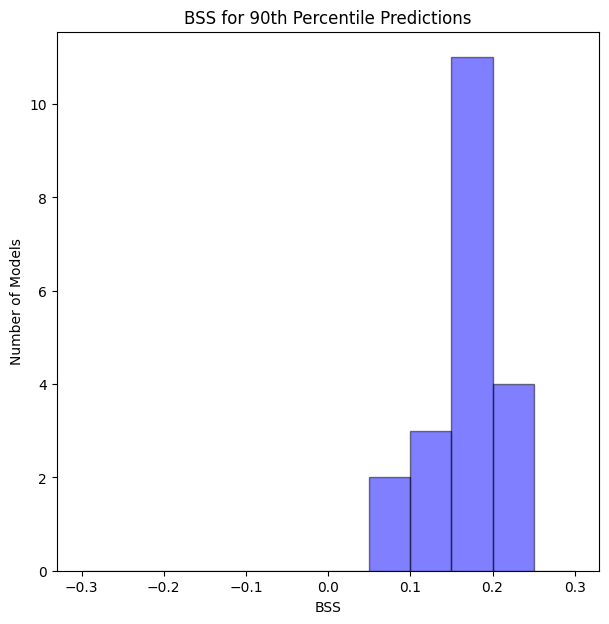

In [36]:
bins = np.linspace(-0.3, 0.3,13)
counts, edges, = np.histogram(BSS_90[:], bins=bins)

fig, (ax1) = plt.subplots(1,1, figsize=(7,7))

ax1.bar(edges[:-1], counts, width=np.diff(edges), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax1.set_xlabel('BSS')
ax1.set_ylabel('Number of Models')
ax1.set_title('BSS for 90th Percentile Predictions')
plt.savefig("BSS90.png")

Text(0.5, 0.98, 'BSS for Predictions Across Datasets')

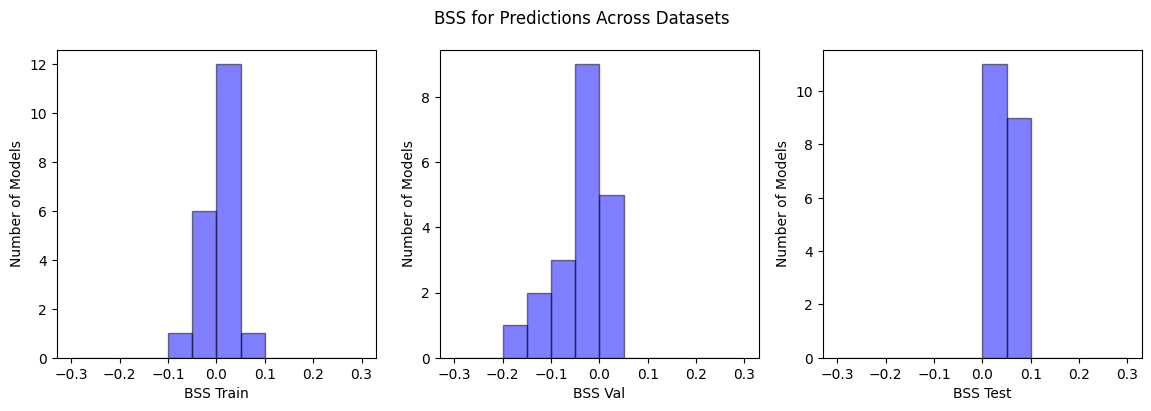

In [55]:
bins = np.linspace(-0.3, 0.3,13)
counts1, edges1, = np.histogram(BSS_train[:], bins=bins)
counts2, edges2, = np.histogram(BSS_val[:], bins=bins)
counts3, edges3, = np.histogram(BSS_test[:], bins=bins)

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(14,4))

ax1.bar(edges1[:-1], counts1, width=np.diff(edges1), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax1.set_xlabel('BSS Train')
ax1.set_ylabel('Number of Models')

ax2.bar(edges2[:-1], counts2, width=np.diff(edges2), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax2.set_xlabel('BSS Val')
ax2.set_ylabel('Number of Models')

ax3.bar(edges3[:-1], counts3, width=np.diff(edges3), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax3.set_xlabel('BSS Test')
ax3.set_ylabel('Number of Models')

plt.suptitle('BSS for Predictions Across Datasets')
#plt.savefig("BSS90.png")

In [40]:
len(p_train)

101560

In [41]:
p_test = np.array(p_test)
p_test = p_test.reshape(((27340,2)))

p_train = np.array(p_train)
p_train = p_train.reshape(((101560,2)))

p_val= np.array(p_val)
p_val = p_val.reshape(((27340,2)))

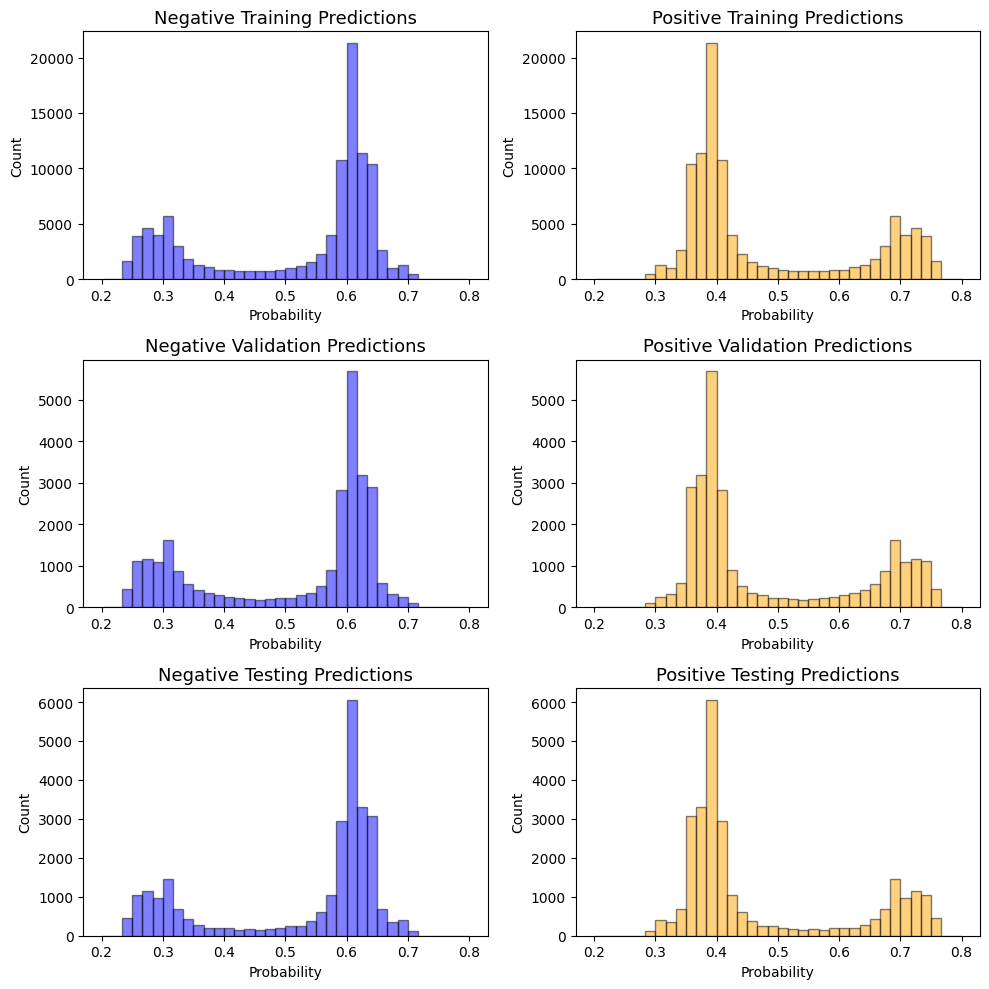

In [42]:
bins = np.linspace(0.2, 0.8, 37)  #10 bins from 0.4 to 1
##bin the probabilities
counts_neg_test, edges_neg_test = np.histogram(p_test[:,0], bins=bins)
counts_pos_test, edges_pos_test = np.histogram(p_test[:,1], bins=bins)

counts_neg_train, edges_neg_train = np.histogram(p_train[:,0], bins=bins)
counts_pos_train, edges_pos_train = np.histogram(p_train[:,1], bins=bins)

counts_neg_val, edges_neg_val = np.histogram(p_val[:,0], bins=bins)
counts_pos_val, edges_pos_val = np.histogram(p_val[:,1], bins=bins)

fig, axes = plt.subplots(3, 2, figsize=(10,10))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

ax1.bar(edges_neg_train[:-1], counts_neg_train, width=np.diff(edges_neg_train), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax1.set_title('Negative Training Predictions', fontsize=13)
ax1.set_xlabel('Probability')
ax1.set_ylabel('Count')

ax2.bar(edges_pos_train[:-1], counts_pos_train, width=np.diff(edges_pos_train), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
ax2.set_title('Positive Training Predictions', fontsize=13)
ax2.set_xlabel('Probability')
ax2.set_ylabel('Count')

ax3.bar(edges_neg_val[:-1], counts_neg_val, width=np.diff(edges_neg_val), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax3.set_title('Negative Validation Predictions', fontsize=13)
ax3.set_xlabel('Probability')
ax3.set_ylabel('Count')

ax4.bar(edges_pos_val[:-1], counts_pos_val, width=np.diff(edges_pos_val), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
ax4.set_title('Positive Validation Predictions', fontsize=13)
ax4.set_xlabel('Probability')
ax4.set_ylabel('Count')

ax5.bar(edges_neg_test[:-1], counts_neg_test, width=np.diff(edges_neg_test), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax5.set_title('Negative Testing Predictions', fontsize=13)
ax5.set_xlabel('Probability')
ax5.set_ylabel('Count')

ax6.bar(edges_pos_test[:-1], counts_pos_test, width=np.diff(edges_pos_test), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
ax6.set_title('Positive Testing Predictions', fontsize=13)
ax6.set_xlabel('Probability')
ax6.set_ylabel('Count')

plt.tight_layout()
#plt.savefig("probability_distrib.png")

### Model Curves. 

In [43]:
tloss = np.mean(train_loss, axis=0)
vloss = np.mean(val_loss, axis=0)
    
cacc= np.mean(cat_acc, axis=0)
vacc= np.mean(val_acc, axis=0)

<bound method Axes.legend of <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Acc'>>

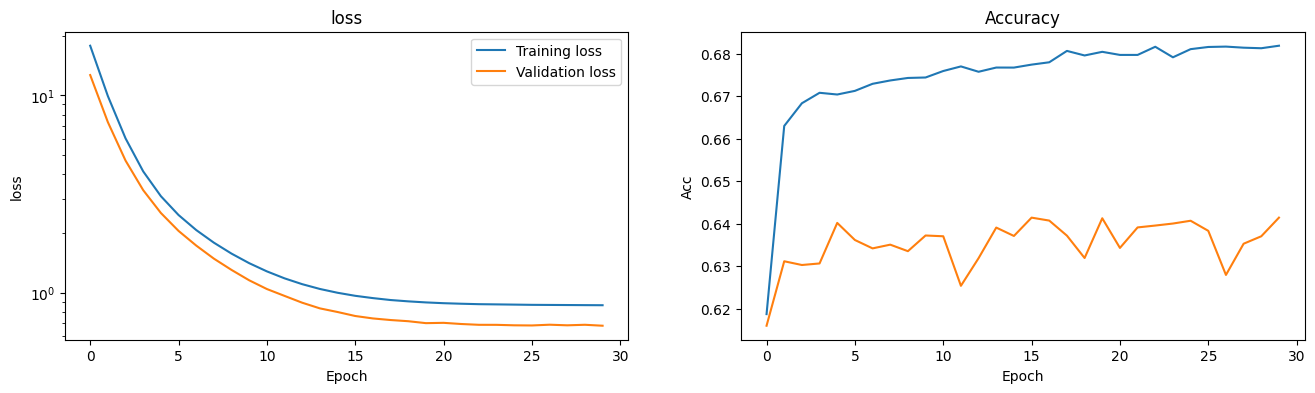

In [44]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=plt.figaspect(0.25))
ax1.plot(tloss, label='Training loss')
ax1.plot(vloss, label='Validation loss')
ax1.set_yscale('log')
ax1.set_title('loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('loss')
ax1.legend()

ax2.plot(cacc, label='Training ACC')
ax2.plot(vacc, label='Validation ACC')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Acc')
ax2.legend

#plt.savefig("EUR_ACC_14.png")

### Skill Score Distributions. 

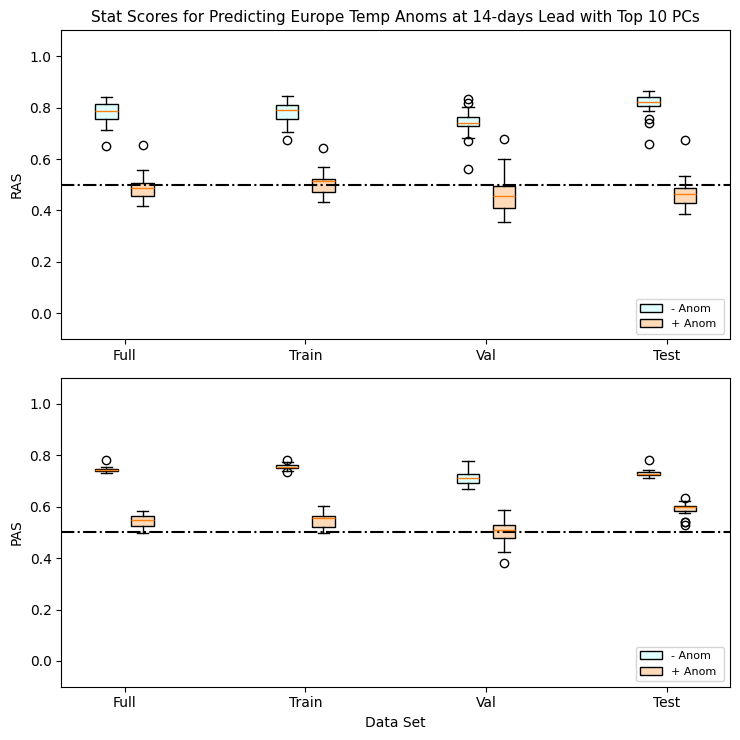

In [47]:
#plot
fig = plt.figure(figsize=(7.5,7.5))
font = 10
#loop through each member
ax2 = plt.subplot(2,1,1)
ax3 = plt.subplot(2,1,2)

ticks = ['Full', 'Train', 'Val', 'Test'] #set tick numbers for dataset
colors = ['lightcyan','peachpuff']
ind = [2, 4, 6, 8]  # the x locations for the groups
w = 0.25 #box-plot width
labels = ['- Anom', '+ Anom '] #labels of quantiles


##begin to go plot by plot ...
#each plot has a separate plot function for each lead time. In these, the plots get each quantile plotted. 
ax2.set_title("Stat Scores for Predicting Europe Temp Anoms at 14-days Lead with Top 10 PCs",fontsize = 11) 

##repeat the process
a2_0 = ax2.boxplot([Rec_all[:,0],Rec_all[:,1]], positions= [1.8,2.2], widths=w, patch_artist=True)
a2_5 = ax2.boxplot([Rec_train[:,0],Rec_train[:,1]], positions=[3.8,4.2], widths=w, patch_artist=True)
a2_10 = ax2.boxplot([Rec_val[:,0],Rec_val[:,1]], positions=[5.8,6.2], widths=w, patch_artist=True)
a2_14 = ax2.boxplot([Rec_test[:,0],Rec_test[:,1]], positions=[7.8,8.2], widths=w, patch_artist=True)
ax2.axhline(0.5, c='k', ls ='-.')
ax2.set_xticks(ind, ticks)
for bplot in (a2_0, a2_5, a2_10, a2_14):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
for patch, label in zip(a2_0['boxes'], labels):
    patch.set_label(label)
#ax2.set_title('RAS for Temperature Region',fontsize = 14)
ax2.set_ylim(-0.1,1.1)
ax2.tick_params(axis='both', which='major', labelsize= font)
ax2.set_ylabel('RAS',fontsize = font)
#ax2.set_xlabel('Data Set',fontsize = 14)
#ax2.set_ylabel('Brier Skill Score')
ax2.legend(loc = 'lower right', fontsize = 8)
ax2.set_aspect('auto') ;

a3_0 = ax3.boxplot([Prec_all[:,0],Prec_all[:,1]], positions= [1.8,2.2], widths=w, patch_artist=True)
a3_5 = ax3.boxplot([Prec_train[:,0],Prec_train[:,1]], positions=[3.8,4.2], widths=w, patch_artist=True)
a3_10 = ax3.boxplot([Prec_val[:,0],Prec_val[:,1]], positions=[5.8,6.2], widths=w, patch_artist=True)
a3_14 = ax3.boxplot([Prec_test[:,0],Prec_test[:,1]], positions=[7.8,8.2], widths=w, patch_artist=True)
ax3.axhline(0.5, c='k', ls ='-.')
ax3.set_xticks(ind, ticks)
for bplot in (a3_0, a3_5, a3_10, a3_14):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
for patch, label in zip(a3_0['boxes'], labels):
    patch.set_label(label)
#ax3.set_title('RAS Well')
#ax3.set_title('PAS for Temperature Region',fontsize = 14)
ax3.set_ylim(-0.1,1.1)
ax3.set_ylabel('PAS',fontsize = font)
ax3.set_xlabel('Data Set',fontsize = font)
#ax3.set_ylabel('Recall Accuracy Score',fontsize = 14)
ax3.tick_params(axis='both', which='major', labelsize= font)
ax3.legend(loc = 'lower right', fontsize = 8)
ax3.set_aspect('auto') ;

plt.tight_layout()
#plt.show()
#plt.savefig("EUR_StatScore_14.png", bbox_inches='tight',dpi =150)


### Percentile ACC Plots.

Text(0.5, 1.0, 'Testing Prediction Accuracy Across 20 Models for Europe Temps')

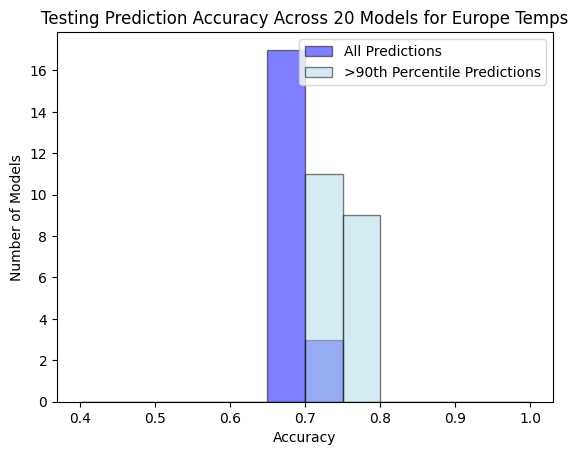

In [48]:
bins = np.linspace(0.4, 1,13)  # 10 bins from 0.4 to 1
##bin the testing 90th percentile accuracy data
counts90, edges90 = np.histogram(test90_acc, bins=bins)
countsfull, edgesfull = np.histogram(fulltest_acc, bins=bins)
# Plot the full dataset
#offset = 0.02  # Adjust this value if needed for better visibility
plt.bar(edgesfull[:-1], countsfull, width=np.diff(edgesfull), 
        edgecolor='black', alpha=0.5, label='All Predictions', align='edge', color='blue')
# Plot the 90th percentile
plt.bar(edges90[:-1], counts90, width=np.diff(edges90), 
        edgecolor='black', alpha=0.5, label='>90th Percentile Predictions', align='edge', color = 'lightblue')
plt.xlabel('Accuracy')
plt.ylabel('Number of Models')
plt.legend()
plt.title('Testing Prediction Accuracy Across 20 Models for Europe Temps')
#plt.savefig("EUR14_ACCtesting.png")

### SHAP.

In [ ]:
#try SHAP with this model
import shap

X_test = X_tes[:10].reshape(10, -1)

# Create wrapper for reshaped input
def model_wrapper(x):
    x = x.reshape((-1, 14, 10))  # reshape back to model input shape
    return model.predict(x)

explainer = shap.KernelExplainer(model_wrapper,X_test)

In [ ]:
shap_values = explainer.shap_values(X_test)
shap_obj = explainer(X_test)

In [ ]:
shap_obj.shape

In [ ]:
shap_obj2 = np.array(shap_obj)  

shap_obj_reshaped = shap_obj2.reshape(10, 14, 10, 2)

print(shap_obj_reshaped.shape)

In [ ]:
#shap_obj_reshaped = np.mean(shap_obj_reshaped, axis=1)
shap_values_flat = np.mean(shap_obj_reshaped, axis=1)
print(shap_values_flat.shape)

feature_names =["1", "56", "0", "54", "9", "57", "55", "3", "26", "4"]

X_data_dummy = np.zeros_like(shap_values_flat[..., 0])
# For class 0
explainer0 = shap.Explanation(
    values=shap_values_flat[..., 0],       # (10 samples, 10 features)
    data=X_data_dummy,                     # (10 samples, 10 features)
    feature_names=feature_names
)

# For class 1
explainer1 = shap.Explanation(
    values=shap_values_flat[..., 1],
    data=X_data_dummy,
    feature_names=feature_names
)

In [ ]:
#plot
fig = plt.figure(figsize=(7.5,7.5))
font = 10
#loop through each member
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)

ax1.set_title("SHAP Values for Classifying Negtive Temp Anomalies +14 Days Lead for Europe",fontsize =14, y = 1.05)
ax1 = shap.plots.beeswarm(explainer0, show = False) ##for negative classifications ... this is physically consistent!
#ax1.set_xlim(-0.2,0.2)  

ax2.set_title("SHAP Values for Classifying Positive Temp Anomalies +14 Days Lead for Europe",fontsize =14, y = 1.05)
ax2 = shap.plots.beeswarm(explainer1, show = False) ##for negative classifications ... this is physically consistent!
#ax2.set_xlim(-0.2,0.2)  

In [ ]:
#selected indices
##Europe
#Index([1, 56, 0, 54, 9, 57, 55, 3, 26, 4], dtype='int64')

##Nova
#Index([1, 56, 0, 55, 2, 53, 54, 9, 4, 22], dtype='int64')

##South
#Index([1, 56, 54, 53, 55, 4, 3, 21, 14, 0], dtype='int64')

In [ ]:
fig, ax = plt.title("SHAP Values for Classifying Negative Temp Anomalies +14 Days Lead",fontsize =14, y = 1.05)
ax = shap.plots.beeswarm(shap_obj[:,:,0], show = False) ##for negative classifications ... this is physically consistent!
ax.set_xlim(-0.2,0.2)  
#plt.savefig("RFshap_Neg_Pred_14days.png")

In [ ]:
plt.title("SHAP Values for Classifying Positive Temp Anomalies +14 Days Lead",fontsize =14, y = 1.05)
ax = shap.plots.beeswarm(shap_obj[:,:,1], show = False) ##for positive classifications ... this is physically consistent!
ax.set_xlim(-0.2,0.2)
#plt.savefig("RFshap_Pos_Pred_14days.png")